# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib

data_type = 'float32'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import pycell2location

from matplotlib import rcParams
import seaborn as sns
import itertools
import scipy

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

## Load input data 

First we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/samples_2_v2/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/'

seed_numbers = ['335', '604', '10']
seed_numbers = seed_numbers[2]

# load simulated spatial data desing
design = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_design.csv',
                    index_col=0)
design.index = ['ref_' + i for i in design.index]

# read anndata with sampled gene_levels
downsampled_suff = ''
adata = anndata.read(f'{sp_data_folder}synthetic_ST_seed{seed_numbers}_counts_downsampled{downsampled_suff}.h5ad')
adata.obs.columns = ['ref_' + i for i in adata.obs.columns]
adata.X = scipy.sparse.csr_matrix(adata.X)
sc.pp.calculate_qc_metrics(adata, inplace=True) 
slides = {'seed'+seed_numbers: adata}
adata_0 = adata.copy()

# load single cell reference used for simulation (validation set)
counts_validation = pickle.load(open(sp_data_folder + 'counts_validation_'+seed_numbers+'.p', 'rb'))
labels_validation = pickle.load(open(sp_data_folder + 'labels_validation_'+seed_numbers+'.p', 'rb'))
adata_snrna_raw = anndata.AnnData(counts_validation, obs=labels_validation)
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

design, adata_snrna_raw

(                 uniform  density  nspots  mean_ncells
 ref_Astro_3            0      1.0   160.0     1.047457
 ref_Ext_L25            0      1.0   179.0     2.132758
 ref_Ext_L6             0      1.0   197.0     1.123235
 ref_Oligo_2            0      1.0   180.0     0.059803
 ref_Ext_Hpc_1          0      1.0   145.0     1.165331
 ref_Inh_Meis2_4        0      1.0   224.0     0.899732
 ref_Nb_2               0      0.0   182.0     1.725271
 ref_Ext_L23            0      0.0   184.0     2.634801
 ref_Inh_Pvalb          1      1.0  1729.0     1.344651
 ref_Inh_Vip            0      1.0   218.0     0.243348
 ref_Ext_L5_1           0      0.0   237.0     3.911688
 ref_Inh_4              0      1.0   239.0     0.770593
 ref_Ext_Thal_1         0      1.0   243.0     0.328724
 ref_Inh_Meis2_3        1      0.0  1480.0     3.129082
 ref_Ext_Hpc_2          0      1.0   170.0     1.953083
 ref_Inh_6              0      1.0   226.0     1.563946
 ref_Inh_3              0      0.0   226.0     2

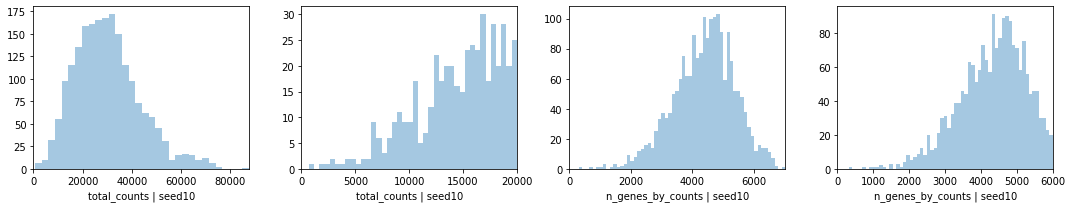

In [3]:
# PLOT QC FOR EACH SAMPLE 
if len(slides) > 2:
    figsize = 4*len(slides)-4
else:
    figsize = 4*len(slides)-1
    
fig, axs = plt.subplots(len(slides), 4, figsize=(15, figsize))
axs = axs.reshape((len(slides), 4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

Add counts matrix as `adata.raw` 

In [4]:
# Select genes expressed by at least 2% of cells in each cluster.
adata_snrna_raw_bin = adata_snrna_raw.copy()
adata_snrna_raw_bin.X = adata_snrna_raw_bin.X > 0
adata_snrna_raw_bin.raw = adata_snrna_raw_bin
prop_expressed = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw_bin, 'annotation_1')
prop_expressed = prop_expressed.loc[adata_snrna_raw.var_names,:]
adata_snrna_raw = adata_snrna_raw[:, prop_expressed.max(1) > 0.02]

In [5]:
adata_vis = adata.copy()
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

adata_vis.var['ENSEMBL'] = adata_vis.var_names
adata_vis.obs['sample'] = seed_numbers

from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

#### Select genes using expression in non-zero cells

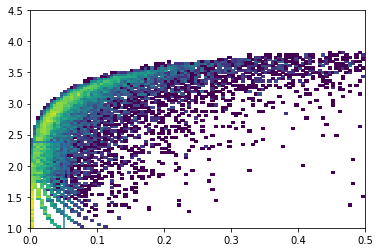

In [6]:
# Select cells
#min_genes = 1000  
rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.001)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

In [7]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(8137, 12247)

In [8]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

In [9]:
adata_snrna_raw

View of AnnData object with n_obs × n_vars = 8137 × 12247
    obs: 'annotation_1', 'sample', 'n_genes'
    var: 'n_cells', 'nonz_mean'

#### Plot numbers of cells per spot

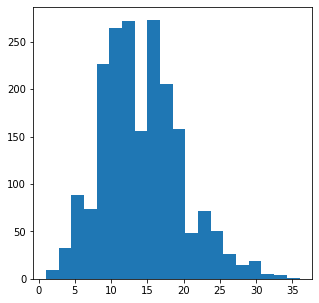

In [10]:
rcParams['figure.figsize'] = 5, 5
cell_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' not in i)
                               for i in adata.obs.columns]]
plt.hist(cell_count.sum(1), bins=20);

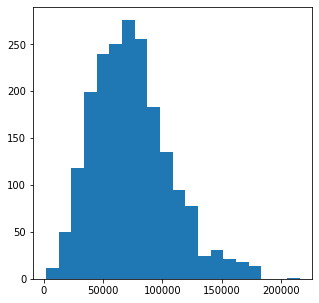

In [11]:
umi_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' in i)
                               for i in adata.obs.columns]]
plt.hist(umi_count.sum(1), bins=20);

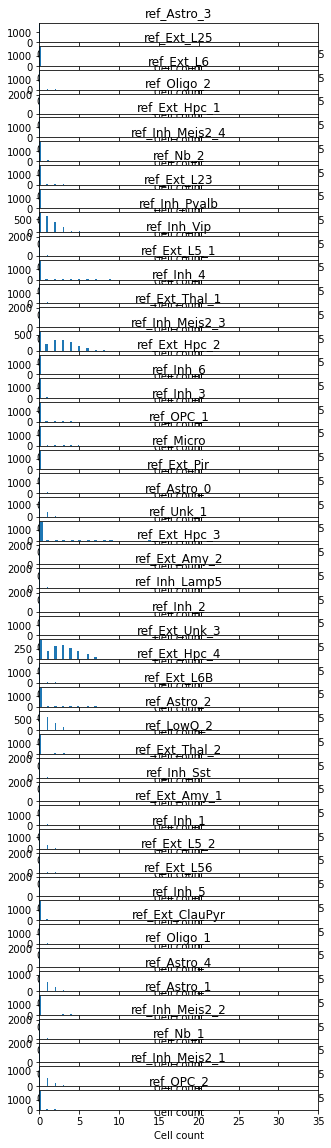

In [12]:
rcParams['figure.figsize'] = 5, 20
for i, c in enumerate(cell_count.columns):
    plt.subplot(cell_count.shape[1], 1, i+1)
    plt.hist(cell_count[c], bins = 35);
    plt.xlabel('Cell count');
    plt.xlim(0, 35);
    plt.title(str(c));
plt.tight_layout()

#!cd /nfs/team283/vk7/software/ && git clone https://github.com/YosefLab/scvi-tools.git
!cd /nfs/team283/vk7/software/scvi-tools/ && git pull
!cd /nfs/team283/vk7/software/scvi-tools/ && git checkout romain/spatial
!cd /nfs/team283/vk7/software/scvi-tools/ && python setup.py install

#!pip install rich
!pip install git+https://github.com/YosefLab/scvi-tools.git@ea693d8425dc6b4a077165a8ddc33443ed973670 --upgrade
#!pip install scvi-tools --upgrade
#!pip install scikit-misc --force

## Perform scVI signature estimation

In [13]:
from scvi.data import register_tensor_from_anndata
from scvi.model.stereoscope import scStereoscope, stStereoscope
import scvi

rcParams['figure.figsize'] = 5, 5

In [14]:
adata_snrna_raw.layers["counts"] = adata_snrna_raw.X.copy()
sc.pp.normalize_total(adata_snrna_raw, target_sum = 10e4)
sc.pp.log1p(adata_snrna_raw)
adata_snrna_raw.raw = adata_snrna_raw

In [15]:
scvi.data.setup_anndata(adata_snrna_raw, layer = "counts", labels_key = "annotation_1")

adata_snrna_raw.obs["indices"] = np.arange(adata_snrna_raw.n_obs)
register_tensor_from_anndata(adata_snrna_raw, "ind_x", "obs", "indices")

model = scStereoscope(adata_snrna_raw)
model.train(lr = 0.01, n_epochs = 1000, frequency = 1)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["annotation_1"]                                         
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 8137 cells, 12247 genes, 1        
         batches, 46 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 1000 epochs                                                            
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  369 s. / 1000 epochs                                                


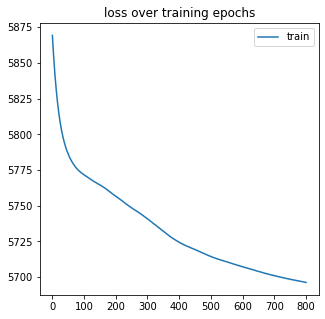

In [16]:
plt.plot(model.history["elbo_train_set"][200:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [17]:
params = model.get_params()
params[0].shape
model.save(f"{results_folder}scvi_stereoscope/scmodel_1k.pkl", overwrite = True)

- Filter genes to be the same as the scRNA-Seq data

In [18]:
#intersect = np.intersect1d(adata_snrna_raw.var_names, adata.var_names)
#adata = adata[:, intersect].copy()
adata = adata[:, adata_snrna_raw.var_names].copy()

#mask = [x in intersect for x in adata_snrna_raw.var_names]
#params = [params[0][mask, :], params[1][mask]]
len(adata_snrna_raw.var_names) == params[0].shape[0]

True

In [19]:
adata.layers["counts"] = adata.X.copy()
scvi.data.setup_anndata(adata, layer = "counts")

adata.obs["indices"] = np.arange(adata.n_obs)
register_tensor_from_anndata(adata, "ind_x", "obs", "indices")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2000 cells, 12247 genes, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [20]:
spatial_model = stStereoscope(adata, params)
spatial_model.train(lr = 0.01, n_epochs = 20000, train_size = 1, frequency = 1)

INFO     Training for 20000 epochs                                                           
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  3662 s. / 20000 epochs                                              


In [21]:
help(spatial_model.train)

Help on method train in module scvi.model.stereoscope:

train(n_epochs: Union[int, NoneType] = None, train_size: float = 0.9, test_size: Union[float, NoneType] = None, lr: float = 0.001, frequency: Union[int, NoneType] = None, train_fun_kwargs: dict = {}, **kwargs) method of scvi.model.stereoscope.stStereoscope instance



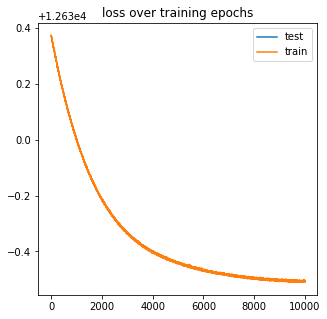

In [28]:
plt.plot(spatial_model.history["elbo_test_set"][10000:], label = "test")
plt.plot(spatial_model.history["elbo_train_set"][10000:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [23]:
import pandas as pd
adata.obsm["deconvolution"] = pd.DataFrame(data = spatial_model.get_proportions(), index = adata.obs.index, 
                                           columns = adata_snrna_raw.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"])


In [24]:
for ct in adata.obsm["deconvolution"].columns:
    adata.obs[ct] = adata.obsm["deconvolution"][ct]

In [25]:
adata.obsm["deconvolution"].sum(1)

Spotx1       1.0
Spotx2       1.0
Spotx3       1.0
Spotx4       1.0
Spotx5       1.0
            ... 
Spotx1996    1.0
Spotx1997    1.0
Spotx1998    1.0
Spotx1999    1.0
Spotx2000    1.0
Length: 2000, dtype: float32

In [26]:
spatial_model

stDeconv Model with params: 
gene_likelihood: nb
Training status: Trained

In [27]:
adata.write(f"{results_folder}scvi_stereoscope/sp_n_epochs20k.h5ad")